# Task, background, and motivation
A term deposit is a deposit held at a financial institution that has a fixed term, which is a few months or a few years. When a term deposit is purchased, the customer understands that the money can only be withdrawn after the term has ended. Term deposits are an extremely safe investment and are therefore very appealing to conservative, low-risk investors. Term deposits, because they allow banks to hold onto a deposit for a specific amount of time, allow banks to invest in higher gain financial products. Thus, it’s beneficial for banks to sell term deposits.

In a Portuguese retail bank, the human agents contact a list of clients to sell the bank’s long-term deposits. The response is success or not, as whether the customer would like to buy the deposit or not. Tens of thousands of calls are executed, however, only 12.38% are successful. 

Contacting only clients who are more likely to subscribe could reduce costs, leading to more profits. Therefore, our task is to predict the success of telemarketing calls for selling bank long-term deposits using several classifiers. Then compare the performance of each classifier and explore what features are important.

# Dataset
The data were collected from a Portuguese banking institution. There are 41188 instances in the dataset and each instance contains 20 attributes, including client information, social and economic context attributes, and one output target, which is the contact outcome {‘yes’, ‘no’} (positive, negative).

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn import preprocessing
import argparse
import numpy as np
import scipy
import csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.grid_search import ParameterGrid
import pylab as pl
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from scipy import interp
from sklearn.cross_validation import StratifiedKFold
import math
import sys
import itertools
from operator import itemgetter
from sklearn.feature_selection import RFECV
import random
%matplotlib inline

Our assumptions on term deposit price, term deposit cost, and contact cost:<br>
(We will explain the meaning of these terms later.)

In [3]:
TERM_DEPOSIT_PRICE = 20
TERM_DEPOSIT_COST = 10
CONTACT_COST = 3
if TERM_DEPOSIT_PRICE - TERM_DEPOSIT_COST - CONTACT_COST <= 0:
    print("Invalid input")

Create feature_names list, which is used when we want to present what features are important.

In [4]:
# dataset doesn't have month == 'jan' & 'feb'
raw_numeric_features = [
            'age',
            'duration',
            'campaign',
            'pdays',
            'previous',
            'emp.var.rate',
            'cons.price.idx',
            'cons.conf.idx',
            'euribor3m',
            'nr.employed']
raw_categorical_features = [['admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown_job'],
                            ['divorced','married','single','unknown_marital'],
                            ['basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown_education'],
                            ['no_default','yes_default','unknown_default'],
                            ['no_housing','yes_housing','unknown_housing'],
                            ['no_loan','yes_loan','unknown_loan'],
                            ['cellular','telephone'],
                            ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],
                            ['mon','tue','wed','thu','fri'],
                            ['failure','nonexistent','success']]
feature_names = []
for categorical_feature in raw_categorical_features:
    feature_names += sorted(categorical_feature)
feature_names += raw_numeric_features

# Data initial exploration

In [5]:
data = pd.read_csv('bank-additional-full.csv', delimiter=';')

# show summary statistics
data.describe().round(3).head(8)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.000,41188.000,41188.000,41188.000,41188.000,41188.000,41188.000,41188.000,41188.000,41188.000
mean,40.024,258.285,2.568,962.475,0.173,0.082,93.576,-40.503,3.621,5167.036
std,10.421,259.279,2.770,186.911,0.495,1.571,0.579,4.628,1.734,72.252
min,17.000,0.000,1.000,0.000,0.000,-3.400,92.201,-50.800,0.634,4963.600
25%,32.000,102.000,1.000,999.000,0.000,-1.800,93.075,-42.700,1.344,5099.100
50%,38.000,180.000,2.000,999.000,0.000,1.100,93.749,-41.800,4.857,5191.000
75%,47.000,319.000,3.000,999.000,0.000,1.400,93.994,-36.400,4.961,5228.100
max,98.000,4918.000,56.000,999.000,7.000,1.400,94.767,-26.900,5.045,5228.100


We show the summary statistics for all the numerical features. The result is reasonable.<br>
Attribute 'pdays' is the number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted). So from the summary statistics, we can see that there are many data whose 'pdays' equals 999. This means this dataset recorded many new clients.

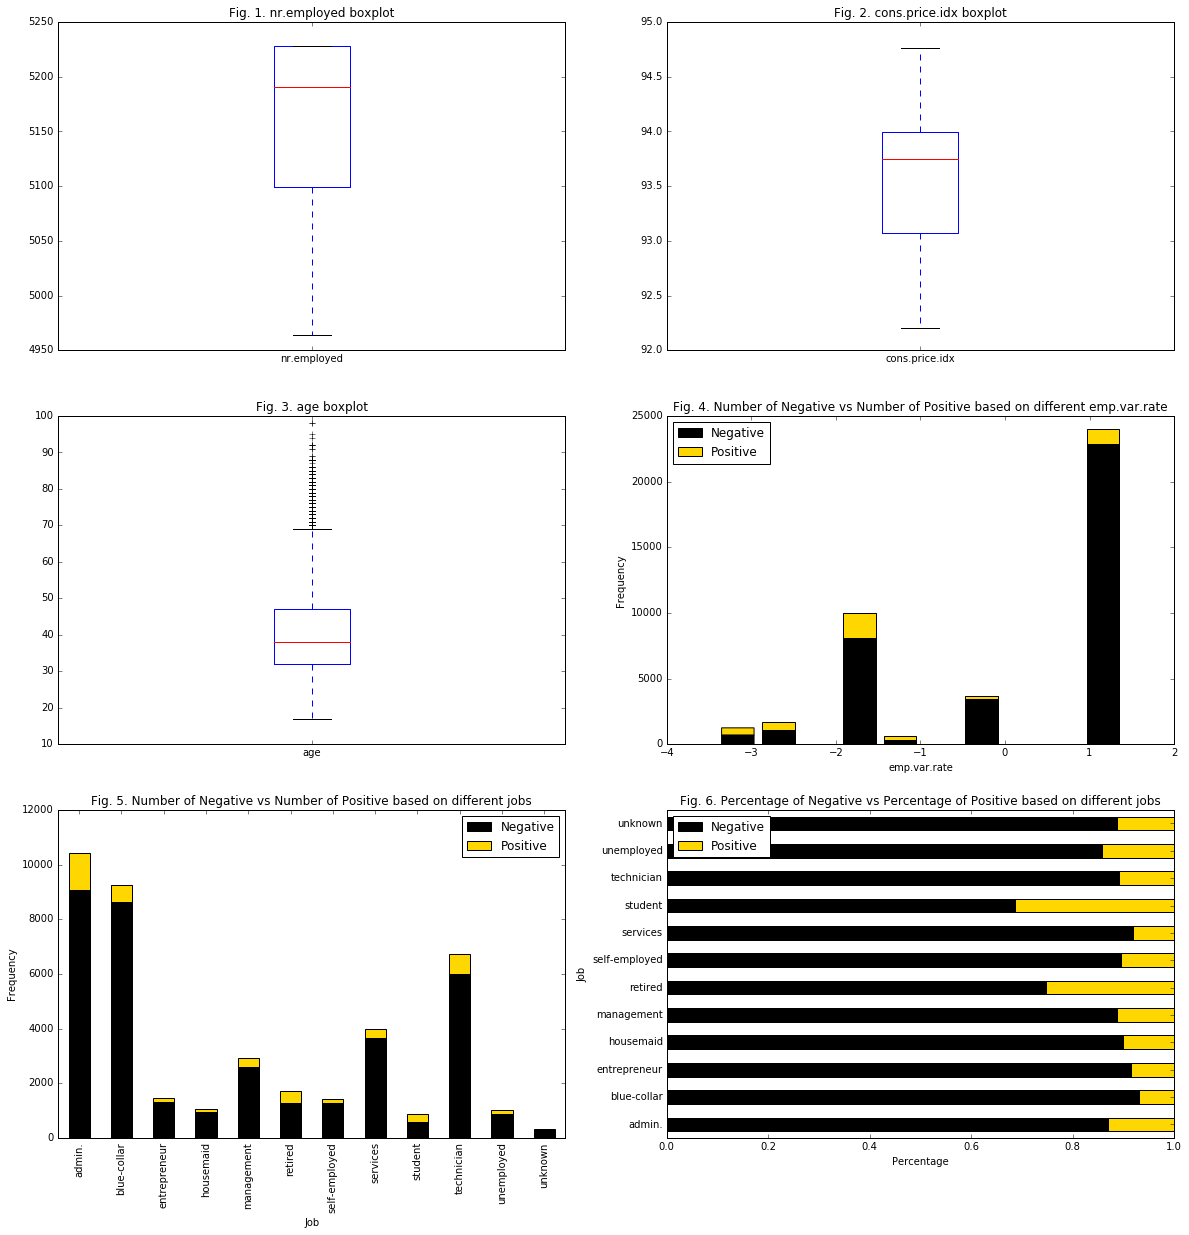

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
labels = ["Negative", "Positive"]

# Label Encoding. Encode y (target)
lab = preprocessing.LabelEncoder()
data.y = lab.fit_transform(data.y)

# visualize the data
data.boxplot(column='nr.employed', grid=False, ax=axs[0, 0], return_type='axes');
axs[0, 0].set(title='Fig. 1. nr.employed boxplot')

data.boxplot(column='cons.price.idx', grid=False, ax=axs[0, 1], return_type='axes');
axs[0, 1].set(title='Fig. 2. cons.price.idx boxplot')

data.boxplot(column='age', grid=False, ax=axs[1, 0], return_type='axes');
axs[1, 0].set(title='Fig. 3. age boxplot')


axs[1, 1].set(xlabel="emp.var.rate", ylabel="Frequency", title='Fig. 4. Number of Negative vs Number of Positive based on different emp.var.rate')
axs[1, 1].hist([data[data.y == 0]['emp.var.rate'], data[data.y == 1]['emp.var.rate']], stacked=True
               , color=['black','gold']);
axs[1, 1].legend(labels, loc='best')


yes_counts = pd.crosstab([data.job], data.y.astype(bool))
yes_counts.plot(kind='bar', stacked=True, color=['black', 'gold'], grid=False, ax=axs[2, 0])
axs[2, 0].legend(labels, loc='best')
axs[2, 0].set(xlabel="Job", ylabel="Frequency", title='Fig. 5. Number of Negative vs Number of Positive based on different jobs')

yes_counts.div(yes_counts.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True, color=['black','gold'], ax=axs[2, 1])
axs[2, 1].legend(labels, loc='best')
axs[2, 1].set(xlabel="Percentage", ylabel="Job", title='Fig. 6. Percentage of Negative vs Percentage of Positive based on different jobs')

Label Negative means the customer refuses to buy term deposit. Label Positive means the customer accepts to buy term deposit.

We compare the number of positive and negative based on different employment variation rate (emp.var.rate). Employment variation rate is the change in the number of employed persons, which is expressed as percentage. So if the employment variation rate is a large negative number, the economy is very bad. If it’s a large positive number, the economy is very good. The result is in line with expectations. When the economy is bad (employment variation rate is smaller than -1), people tend to buy term deposit because its financial risk is small. When the economy is healthier, people prefer not to buy term deposit because the profit of term deposit is not very high; in other words, it’s too conservative. They probably prefer to use their money to do other investments such as stocks where both the profit and the risk are higher than term deposits.

We compare the number of positive and negative based on different jobs. The result is also reasonable. Retired people and students tend to buy term deposits because they usually don't have time or ability to do other high risk and high profit investments. So they tend to choose a safe and conservative way to manage their money.

We also plot some boxplots and the results also look reasonable. And we can see that this dataset also recorded some data with people at very high age.

# Data pre-processing
Since the feature space is large (high-dimensional), we use L2 regularization in linear SVM and Logistic regression. And because regularization assumes normalized input, we need to normalize each numerical feature to range [-1, 1] for SVM and Logistic regression.

In addition, we encode categorical values into integers and take these encoded values as one hot encoder’s input. 

We split our data into training set and test set randomly, where test set takes 40% of the total data. Training dataset is 24712× 63. Testing dataset is 16476 × 63.

In [7]:
# a function to scale numerical features to range [-1, 1]
def scale_numerical(data, numeric_features):
    k = 0 # column index
    data_for_scale = data.values
    for i in data:  # for every column
        if i in numeric_features:
            min_i = min(data[i])
            max_i = max(data[i]) 
            mean_i = data[i].mean()
            for j in range(len(data)):
                temp = data[i][j] * 1.0
                data_for_scale[j, k] = (temp - mean_i) / (max_i - mean_i if max_i - mean_i > mean_i - min_i else mean_i - min_i) 
        k += 1
    return data_for_scale 

In [8]:
# Encode categorical values into integer.
data.job = lab.fit_transform(data.job)
data.marital = lab.fit_transform(data.marital)
data.education = lab.fit_transform(data.education)
data.default = lab.fit_transform(data.default)
data.housing = lab.fit_transform(data.housing)
data.loan = lab.fit_transform(data.loan)
data.contact = lab.fit_transform(data.contact)
data.month = lab.fit_transform(data.month)
data['day_of_week'] = lab.fit_transform(data['day_of_week'])
data.poutcome = lab.fit_transform(data.poutcome)

In [9]:
features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
        'contact', 'month', 'day_of_week','duration', 'campaign', 'pdays', 'previous',
        'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
        'euribor3m', 'nr.employed', 'y']

# scale numerical features to range [-1, 1]
scaled_data_values = scale_numerical(data, raw_numeric_features) # an array with numerical values scaled
scaled_data = pd.DataFrame(scaled_data_values, columns = features) # transfer array to DataFrame

In [10]:
def split_data(data):
    features = data.as_matrix() # features shape: (41188, 21)
    target = features[:, 20]
    features_numeric = features[:, 0:20] # shape: (41188, 20) (index 20 won't be included)
    
    # One-k-scheme encoding
    cat_indices = np.array([[1,2,3,4,5,6,7,8,9,14]])
    enc = OneHotEncoder(categorical_features = cat_indices)
    encoded_features1 = enc.fit_transform(features_numeric)
    
    # Splitting data
    X_train, X_test, Y_train, Y_test = train_test_split(encoded_features1.todense(), 
                                                        target, test_size=0.4, random_state=0)
    return (X_train, X_test, Y_train, Y_test)

In [11]:
X_train, X_test, Y_train, Y_test = split_data(data)
X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled = split_data(scaled_data)

# Analyses
We applied random forest (RF), SVM, Logistic regression (LR), decision tree (DT) to the dataset. In regards to SVM, we use SGD classifier with hinge loss and L2 regularization to achieve the same objective as linear SVM. We try a variety of parameters to find the best parameters of each model. 

For each combination of parameters, we calculate scores by cross validation, where cv = 5 and scoring = "roc_auc".  The combination that have the highest mean scores is the best parameters. The classifier with the best parameters, in our case, is called best_model. 

In [12]:
# Specify how many important features to show
NUM_FEATURE_TO_SHOW = 20

In [13]:
def run_all():
    num_models = 5
    fig, axs = plt.subplots(nrows=num_models, ncols=2, figsize=(10, 25)) # figsize=(20, 50)
    # SGD
    result_SGD = run_classifier(2, X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, axs, 0)
    
    # LR
    result_LR = run_classifier(3, X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, axs, 1)
    
    # DT
    result_DT = run_classifier(4, X_train, X_test, Y_train, Y_test, axs, 2)
    
    # RF
    result_RF = run_classifier(1, X_train, X_test, Y_train, Y_test, axs, 3)
    
    # Random guess model
    result_RG = predict_test_by_random_guess_model(Y_test, axs, 4, 1)
    
    
    evaluation_result = pd.DataFrame({'AUC': [result_SGD[0], result_LR[0], result_DT[0], result_RF[0], result_RG[0]], 'Profit': [result_SGD[1], result_LR[1], result_DT[1], result_RF[1], result_RG[1]]}, 
                                index=['SGD Classifier', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Random Guess'])
    
    important_feature_list = []
    length = 0
    for item in zip(result_SGD[2], result_LR[2], result_DT[2], result_RF[2]):
        important_feature_list.append([item[0], item[1], item[2], item[3]])
        length += 1
    feature_explore_result = pd.DataFrame(important_feature_list, index=range(length), columns=['SGD Classifier', 'Logistic Regression', 'Decision Tree', 'Random Forest'])
    
    return {'evaluation_result': evaluation_result, 'feature_explore_result': feature_explore_result}


def run_classifier(classifier_id, X_train, X_test, Y_train, Y_test, axs, fig_row_idx):    
    classifiers = (None, RandomForestClassifier, SGDClassifier, LogisticRegression, DecisionTreeClassifier)
    classifier_name_list = (None, "RandomForestClassifier", "SGDClassifier", "Logistic Regression", "Decision Trees")
    print("\n################################## Run %s ##################################\n" % classifier_name_list[classifier_id])
    print("# Train:")

    grid_RF = [{'max_depth': [5, 10, 15], 'criterion': ['entropy', 'gini'], 'n_estimators': [50, 100, 250], 'class_weight': ['balanced']}]
    
    grid_SGD = [{'loss': ['hinge'], 'penalty': ['l2'], 'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001], 'class_weight': ['balanced']}]

    grid_LR = [{'C': [0.001,0.01,1, 10, 100, 1000], 'class_weight': ['balanced']}]

    grid_DT = [{'criterion': ['entropy', 'gini'], 'max_depth': [5, 10, 15]}]

    grids = (None, grid_RF, grid_SGD, grid_LR, grid_DT)
    grid_obj = grids[classifier_id]
    cls_obj = classifiers[classifier_id]

    best_param = None
    best_score = None
    best_model = None

    # Performing cross validation using parameter grid
    for one_param in ParameterGrid(grid_obj):
        cls = cls_obj(**one_param)

        one_score = cross_val_score(cls, X_train, Y_train, cv=5, scoring='roc_auc')
        mscore = one_score.mean()
        

        if ( best_score is None or best_score < mscore): 
            best_param = one_param
            best_score = mscore
            best_model = cls
    
    print("Best param: %s" % repr(best_param))
    
    best_model.fit(X_train, Y_train)    
    
    best_params = get_best_model_params(best_model, X_train, Y_train, classifier_name_list[classifier_id], axs, fig_row_idx)
#     print("From training set, [best_fpr, best_tpr, best_threshold] = %s" % str([float(format(x, '.3f')) for x in best_params]))
    
    result = predict_test(best_model, X_test, Y_test, classifier_name_list[classifier_id], best_params, axs, fig_row_idx)
    
    result.append(explore_features_importance(best_model, classifier_name_list[classifier_id], X_train))
    
    return result

## Evaluation metric: bank profit
First, we need to find the best threshold for each model so it can make prediction based on this threshold. So in function get_best_model_params, we make prediction on training set using our best_model. We need to have a list of false positive rate (fpr) and a list of true positive rate (tpr), so that we can plot each (fpr, tpr) pair, leading to a ROC curve. Using the method “roc_curve” in the sklearn.metrics package, we can obtain a list of fpr, a list of tpr, and a list of thresholds associated with them. Then, we can obtain the best threshold out of the list of thresholds by finding the (fpr, tpr) pair that is closest to (0,1). 

Then in function predict_test, we use best_model to predict each data in the test set as positive or negative based on the best threshold. We check the result with actual output label in the test set, so we can obtain the number of true positive and the number of false positive. 
Bank agents will only call those who are predicted to subscribe the deposit (predicted positive), so no cost are spent on those who are predicted to not subscribe (predicted negative). If the agent successfully sell a deposit to one contacted clients, the bank will earn as much as the price of the term deposit minus total costs. If a deposit is not sold after a call, the bank will spend contacting costs without any earnings. Therefore, we can calculate the profit of the bank: 
### number of TP * (term deposit price - contact cost - term deposit cost) - number of FP * contact cost
where TP is true positive, the clients who both have subscribed the deposit and are predicted to subscribe, FP is false positive, the clients who have not subscribed the deposit but are predicted to subscribe. Term deposit price is the price the bank sells, contact cost is the phone bill expense, term deposit cost stands for all the other extra cost when the bank successfully sells a term deposit to a customer.
## Evaluation metric: AUC
We have shown the ROC plot and AUC of the train set in function get_best_model_params. So in function predict_test, we also show the ROC plot and AUC of the test set. To draw an ROC curve, only the true positive rate (TPR) and false positive rate (FPR) are needed. In our case, the TPR defines how many clients who both have subscribed the deposit and are predicted to subscribe (TP) are among all the subscribed clients; the FPR, on the other hand, defines how many clients who have not subscribed the deposit but are predicted to subscribe(FP) are among all the unsubscribed clients.
## Important features exploration
In function explore_features_importance, we explore important encoded features in each model. We can know what features are important by taking a look at the attribute feature\_importances\_ in our DT and RF models, which is a list of float number ranging from 0 to 1.0. The larger the number, the more important it is. We choose the top 20 important encoded features in DT and RF. In SVM and LR, we also choose the top 20 important encoded features selected by RFECV (recursive feature elimination and cross-validated selection). Finally, we display them in a table, which are sorted from most important to less important.

In [14]:
def get_best_model_params(best_model, x_data, y_data, classifier_name, axs, fig_row_idx):
    if classifier_name == 'SGDClassifier':
        confidence_score = best_model.decision_function(x_data)
        fpr, tpr, thresholds = roc_curve(y_data, confidence_score)
    else:
        probas_ = best_model.predict_proba(x_data) # len(probas_) = size of training set
        fpr, tpr, thresholds = roc_curve(y_data, probas_[:, 1]) # pick prob. of yes(encoded as 1)(corresponds to index 1)

    
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve: %.3f" % roc_auc)    
    plot_roc_curve(fpr, tpr, roc_auc, classifier_name, axs, fig_row_idx, 0)

    
    # find best params
    best_fpr = None
    best_tpr = None
    best_threshold = None
    min_distance = sys.maxsize
    for item in zip(fpr, tpr, thresholds):
        distance = math.sqrt(math.pow(item[0], 2) + math.pow(item[1] - 1, 2))
        if min_distance > distance:
            min_distance = distance
            best_fpr = item[0]
            best_tpr = item[1]
            best_threshold = item[2]    
    
    return [best_fpr, best_tpr, best_threshold]
    
def predict_test(best_model, x_data, y_data, classifier_name, best_params, axs, fig_row_idx):
    print("\n# Evaluate on test set:")
    if classifier_name == 'SGDClassifier':
        confidence_score = best_model.decision_function(x_data)
        fpr, tpr, thresholds = roc_curve(y_data, confidence_score)
    else:
        probas_ = best_model.predict_proba(x_data) # len(probas_) = size of testing set
        fpr, tpr, thresholds = roc_curve(y_data, probas_[:, 1]) # pick prob. of yes(encoded as 1)(corresponds to index 1)
    

    roc_auc = auc(fpr, tpr)
    print("1. Area under the ROC curve: %.3f" % roc_auc)    
    plot_roc_curve(fpr, tpr, roc_auc, classifier_name, axs, fig_row_idx, 1)    
    
    print("2. Assess the model based on price and cost:")
    best_threshold = best_params[2]    
    tp_plus_fn = 0 # actual yes
    tn_plus_fp = 0 # actual no
    tp = 0
    fp = 0
    for item in zip(y_data, confidence_score if classifier_name == 'SGDClassifier' else probas_[:, 1]):
        if item[0] == 1.0:
            tp_plus_fn += 1
        else:
            tn_plus_fp += 1
        
        if item[1] >= best_threshold:
            # predict as positive            
            if item[0] == 1.0:
                tp += 1
            else:
                fp += 1
    test_fpr = fp / tn_plus_fp
    test_tpr = tp / tp_plus_fn
#     print("[test_fpr, test_tpr] = %s" % str([float(format(test_fpr, '.3f')), float(format(test_tpr, '.3f'))]))
    
    profit = -1 * (fp * CONTACT_COST - tp * (TERM_DEPOSIT_PRICE - TERM_DEPOSIT_COST - CONTACT_COST))
    print("Using this best model to do predictions on test set, the profit of the bank is %s USD." % str(profit))
    
    return [roc_auc, profit]

def plot_roc_curve(fpr, tpr, roc_auc, classifier_name, axs, fig_row_idx, fig_col_idx):
    axs[fig_row_idx, fig_col_idx].plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    axs[fig_row_idx, fig_col_idx].plot([0, 1], [0, 1], 'k--')
    if fig_col_idx == 0:
        axs[fig_row_idx, fig_col_idx].set(xlabel="False Positive Rate", ylabel="True Positive Rate", title='Use %s on train set' % classifier_name)
    else:
        axs[fig_row_idx, fig_col_idx].set(xlabel="False Positive Rate", ylabel="True Positive Rate", title='Use %s on test set' % classifier_name)
    axs[fig_row_idx, fig_col_idx].legend(loc="lower right")
    
def explore_features_importance(best_model, classifier_name, X_train):
    if classifier_name == 'Decision Trees' or classifier_name == "RandomForestClassifier":
        importance_to_idx = []
        feature_importances = best_model.feature_importances_
        
        for idx in range(len(feature_importances)):
            importance_to_idx.append((feature_importances[idx], idx))
        sort_importance_to_idx = sorted(importance_to_idx, key=itemgetter(0), reverse=True)
                
        # return top NUM_FEATURE_TO_SHOW features
        return [feature_names[item[1]] for item in sort_importance_to_idx[:NUM_FEATURE_TO_SHOW]]
    else: 
        ranking_to_idx = []
    
        selector = RFECV(best_model, cv=5)
        selector = selector.fit(X_train, Y_train)

        rankings = selector.ranking_
        for idx in range(len(rankings)):
            ranking_to_idx.append((rankings[idx], idx))
        sort_ranking_to_idx = sorted(ranking_to_idx, key=itemgetter(0))
        
        # return top NUM_FEATURE_TO_SHOW features
        return [feature_names[item[1]] for item in sort_ranking_to_idx[:NUM_FEATURE_TO_SHOW]]

To have a reference, we also present the ROC plot, AUC, and profit of a random guess model. Its prediction is based on guess. In other words, it simply tosses a coin. If it’s head, it predicts as positive. If it’s tail, it predicts as negative. (i.e., the bank agent randomly selects clients to sell the bank deposit.)

In [15]:
def predict_test_by_random_guess_model(y_data, axs, fig_row_idx, fig_col_idx):
    print("\n################################## Run Random Guess model on test set ##################################\n")

    probas_ = [0.5] * len(y_data)
    fpr, tpr, thresholds = roc_curve(y_data, probas_)
    
    roc_auc = auc(fpr, tpr)
    print("1. Area under the ROC curve: %.3f" % roc_auc)    
    plot_roc_curve(fpr, tpr, roc_auc, "Random Guess", axs, fig_row_idx, fig_col_idx)    

    print("2. Assess the model based on price and cost:")
    tp_plus_fn = 0 # actual yes
    tn_plus_fp = 0 # actual no
    tp = 0
    fp = 0
    for item in y_data:
        if item == 1.0:
            tp_plus_fn += 1
        else:
            tn_plus_fp += 1
        
        guess = random.getrandbits(1)
        if guess == 1:
            # predict as positive            
            if item == 1.0:
                tp += 1
            else:
                fp += 1
    test_fpr = fp / tn_plus_fp
    test_tpr = tp / tp_plus_fn
#     print("[test_fpr, test_tpr] = %s" % str([float(format(test_fpr, '.3f')), float(format(test_tpr, '.3f'))]))
    
    profit = -1 * (fp * CONTACT_COST - tp * (TERM_DEPOSIT_PRICE - TERM_DEPOSIT_COST - CONTACT_COST))
    print("Using this model to do predictions on test set, the profit of the bank is %s USD." % str(profit))
    
    return [roc_auc, profit]


################################## Run SGDClassifier ##################################

# Train:
Best param: {'loss': 'hinge', 'alpha': 0.001, 'penalty': 'l2', 'class_weight': 'balanced'}
Area under the ROC curve: 0.920

# Evaluate on test set:
1. Area under the ROC curve: 0.919
2. Assess the model based on price and cost:
Using this best model to do predictions on test set, the profit of the bank is 3642 USD.

################################## Run Logistic Regression ##################################

# Train:
Best param: {'class_weight': 'balanced', 'C': 100}
Area under the ROC curve: 0.938

# Evaluate on test set:
1. Area under the ROC curve: 0.939
2. Assess the model based on price and cost:
Using this best model to do predictions on test set, the profit of the bank is 4591 USD.

################################## Run Decision Trees ##################################

# Train:
Best param: {'criterion': 'entropy', 'max_depth': 5}
Area under the ROC curve: 0.936

# Evaluate on te

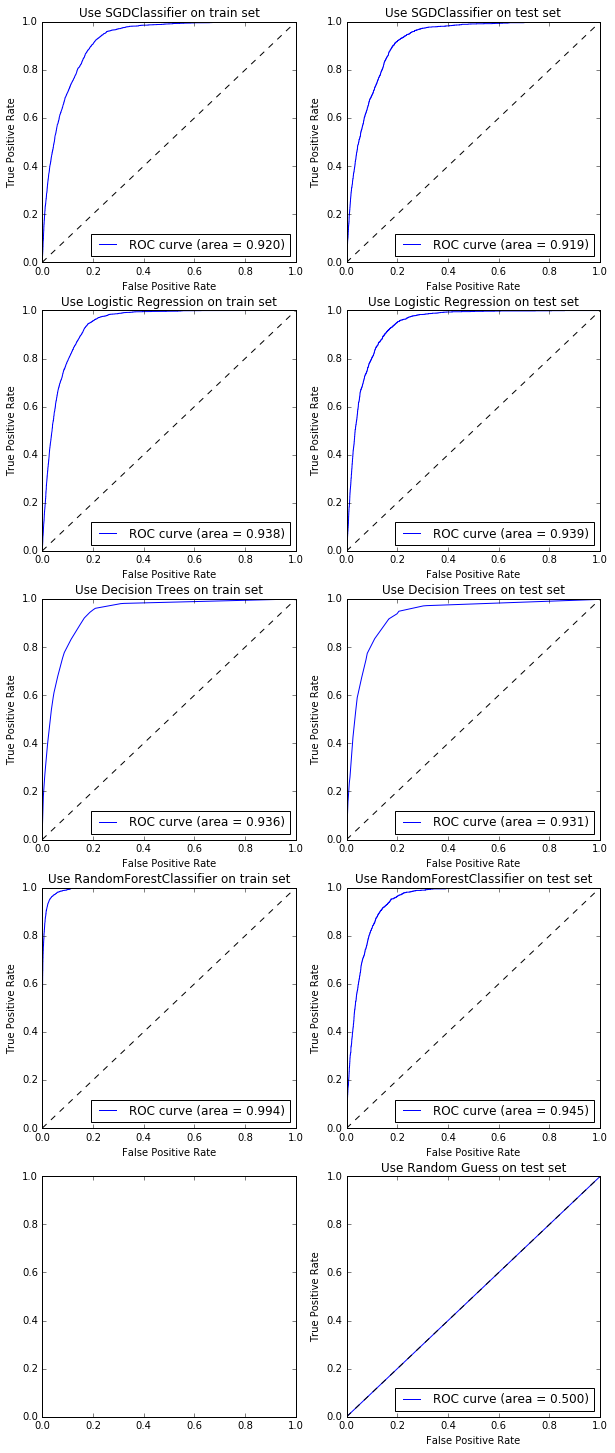

In [24]:
run_result = run_all()

# Summary

In [17]:
print("Assume term deposit price = %d, term deposit cost = %d, contact cost = %d" % (TERM_DEPOSIT_PRICE, TERM_DEPOSIT_COST, CONTACT_COST))
print("profit = number_of_true_positive * (TERM_DEPOSIT_PRICE - TERM_DEPOSIT_COST - CONTACT_COST) - number_of_false_positive * CONTACT_COST")

run_result['evaluation_result'].head()

Assume term deposit price = 20, term deposit cost = 10, contact cost = 3
profit = number_of_true_positive * (TERM_DEPOSIT_PRICE - TERM_DEPOSIT_COST - CONTACT_COST) - number_of_false_positive * CONTACT_COST


,AUC,Profit
SGD Classifier,0.918049,3269
Logistic Regression,0.938518,4591
Decision Tree,0.930706,4782
Random Forest,0.944979,6142
Random Guess,0.500000,-15553


In [25]:
print("Top 20 important features, which are sorted from most important to less important.")        
run_result['feature_explore_result'].head(len(run_result['feature_explore_result'].index))

Top 20 important features, which are sorted from most important to less important.


,SGD Classifier,Logistic Regression,Decision Tree,Random Forest
0,duration,blue-collar,duration,duration
1,nr.employed,housemaid,nr.employed,euribor3m
2,may,management,cons.conf.idx,nr.employed
3,mar,retired,pdays,emp.var.rate
4,pdays,self-employed,euribor3m,age
5,emp.var.rate,services,oct,cons.conf.idx
6,euribor3m,student,cons.price.idx,cons.price.idx
7,nov,unemployed,may,pdays
8,failure,divorced,campaign,campaign
9,sep,married,cellular,success


In [19]:
run_classifier(2, X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, axs, 0)


################################## Run SGDClassifier ##################################

# Train:
Best param: {'loss': 'hinge', 'alpha': 0.001, 'penalty': 'l2', 'class_weight': 'balanced'}
Area under the ROC curve: 0.924

# Evaluate on test set:
1. Area under the ROC curve: 0.925
2. Assess the model based on price and cost:
Using this best model to do predictions on test set, the profit of the bank is 4142 USD.


[0.92467060907180376,
 4142,
 ['retired',
  'self-employed',
  'student',
  'unemployed',
  'divorced',
  'married',
  'unknown_marital',
  'high.school',
  'illiterate',
  'no_default',
  'no_loan',
  'yes_loan',
  'cellular',
  'apr',
  'aug',
  'mar',
  'may',
  'nov',
  'sep',
  'fri']]

In [20]:
run_classifier(2, X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, axs, 0)


################################## Run SGDClassifier ##################################

# Train:
Best param: {'loss': 'hinge', 'alpha': 0.001, 'penalty': 'l2', 'class_weight': 'balanced'}
Area under the ROC curve: 0.921

# Evaluate on test set:
1. Area under the ROC curve: 0.920
2. Assess the model based on price and cost:
Using this best model to do predictions on test set, the profit of the bank is 3370 USD.


[0.92028813544396859,
 3370,
 ['admin.',
  'blue-collar',
  'entrepreneur',
  'retired',
  'self-employed',
  'services',
  'student',
  'divorced',
  'single',
  'unknown_marital',
  'basic.4y',
  'basic.6y',
  'illiterate',
  'professional.course',
  'unknown_education',
  'no_default',
  'no_housing',
  'unknown_housing',
  'no_loan',
  'cellular']]

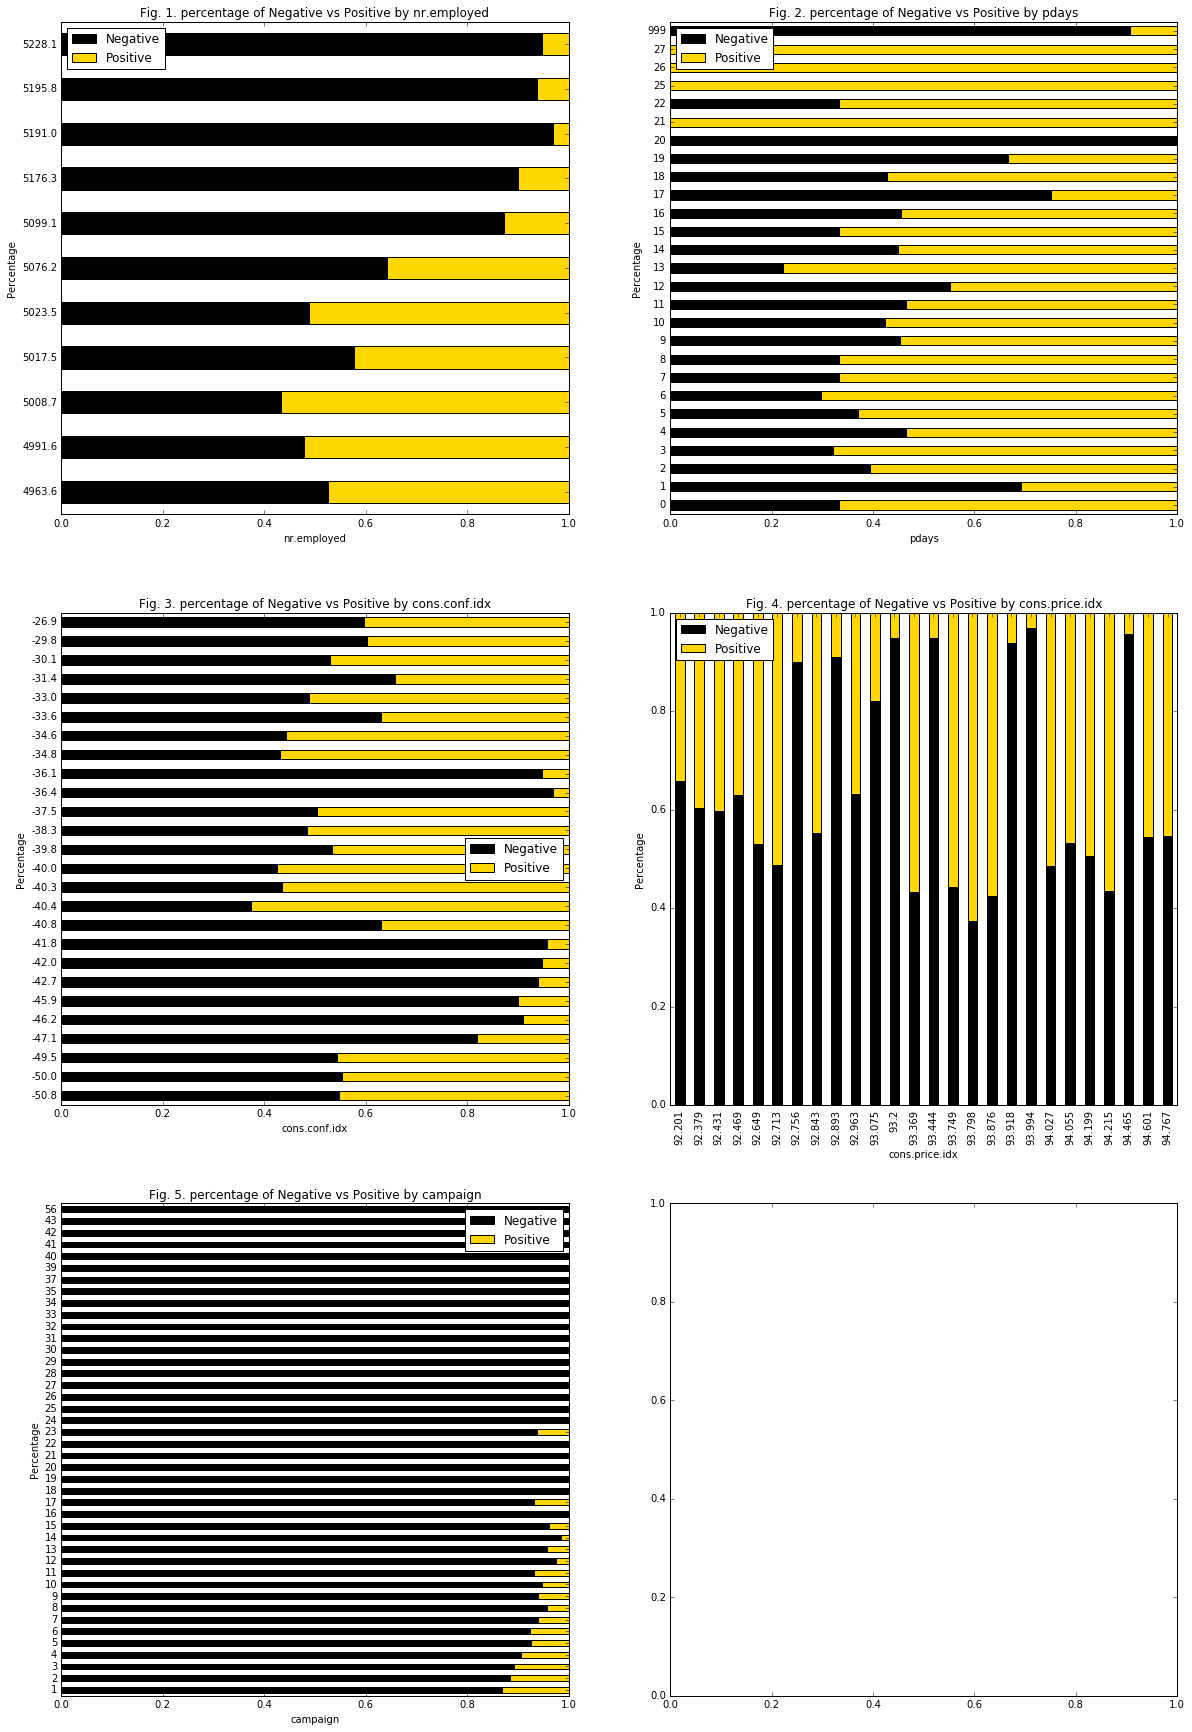

In [21]:
fig2, axs2 = plt.subplots(nrows=3, ncols=2, figsize=(20,30))
labels = ["Negative", "Positive"]

nemployed_counts = pd.crosstab(data['nr.employed'], data.y.astype(bool))
nemployed_counts.apply(lambda r: r/r.sum(), axis=1).plot(kind='barh', stacked=True, color=['black','gold'],ax=axs2[0, 0])
axs2[0, 0].legend(labels, loc='best')
axs2[0, 0].set(xlabel="nr.employed", ylabel="Percentage", title='Fig. 1. percentage of Negative vs Positive by nr.employed')

pdays_counts = pd.crosstab(data.pdays,data.y)
pdays_counts.apply(lambda r: r/r.sum(), axis=1).plot(kind='barh', stacked=True, color=['black', 'gold'], ax=axs2[0, 1])
axs2[0, 1].legend(labels, loc='best')
axs2[0, 1].set(xlabel="pdays", ylabel="Percentage", title='Fig. 2. percentage of Negative vs Positive by pdays')

cci_counts = pd.crosstab(data["cons.conf.idx"], data.y)
cci_counts.apply(lambda r: r/r.sum(), axis=1).plot(kind='barh', stacked=True, color=['black', 'gold'],ax=axs2[1, 0])
axs2[1, 0].legend(labels, loc='best')
axs2[1, 0].set(xlabel="cons.conf.idx", ylabel="Percentage", title='Fig. 3. percentage of Negative vs Positive by cons.conf.idx')

cpi_counts = pd.crosstab(data["cons.price.idx"], data.y)
cpi_counts.apply(lambda r: r/r.sum(), axis=1).plot(kind='bar', stacked=True, color=['black', 'gold'], ax=axs2[1, 1])
axs2[1, 1].legend(labels, loc='best')
axs2[1, 1].set(xlabel="cons.price.idx", ylabel="Percentage", title='Fig. 4. percentage of Negative vs Positive by cons.price.idx')

campaign_counts = pd.crosstab(data["campaign"], data.y)
campaign_counts.apply(lambda r: r/r.sum(), axis=1).plot(kind='barh', stacked=True, color=['black', 'gold'], ax=axs2[2, 0])
axs2[2, 0].legend(labels, loc='best')
axs2[2, 0].set(xlabel="campaign", ylabel="Percentage", title='Fig. 5. percentage of Negative vs Positive by campaign')

we plot percentage of negative vs percentage of positive grouped by features “nr.employed”, “cons.conf.idx”, “pdays”, “cons.price.idx”,”campaign”(the five figures shown above). And we can see that the values of these features indeed have an influence on the outcome.


For example, if the economy is bad (corresponding to the number of employees, nr.employed, is small), the customers are more likely to buy the deposit because term deposit is a safer way to manage money at this time. But if the economy is healthier (corresponding to the number of employees is large), the customers are more likely not to buy term deposits because it is too conservative.

Fig. 5 percentage of negative vs percentage of positive by campaign (campaign means number of contacts performed) shows that most clients subscibe the deposit before 11 calls. Therefore, if the clients still doesn't want to buy the deposit at the 11th call, then the bank agent can stop calling this client.


Other features mentioned above also could tell what kind of clients would like to buy the deposit. 